In [1]:
!pip install -Uqq fastbook
!pip install -Uqq fastai

import fastbook
fastbook.setup_book()

# Chapter 5 - Image Classification
In this chapter we'll dive deeper into the topic of image classification. To make things more interesting and challenging, we'll work on classifying 37 breeds of dogs. Let's get started!

## Input Data Exploration

In [2]:
import fastai.vision.all as fai
path = fai.untar_data(fai.URLs.PETS)

In [3]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
filename = (path/'images').ls()[0]
filename.name

'american_bulldog_56.jpg'

In [5]:
def get_breed_name(filename):
    # fastai provides several utilities to handle regular expressions and other
    # data extraction chores
    return fai.using_attr(fai.RegexLabeller(r'(.+)_\d+\.jpg$'), 'name')(filename)
    # the above could also be accomplished as follows:
    #match = re.match(r'(.+)_\d+\.jpg$', filename.name)
    #return match.groups(1)[0]

files = fai.get_image_files(path/'images')
get_breed_name(files[2])

'english_cocker_spaniel'

It's always a good idea to know how many categories we're dealing with:

In [7]:
breeds = set()
for file in fai.get_image_files(path/'images'):
    breeds.add(get_breed_name(file))
len(breeds)

37

In [6]:
data_template = fai.DataBlock(
    blocks=(fai.ImageBlock, fai.CategoryBlock),
    get_items=fai.get_image_files,
    splitter=fai.RandomSplitter(seed=42),
    get_y=get_breed_name,
    # In the pre-sizing method, we first scale up and then take random 
    # crops of a smaller size
    item_tfms=fai.Resize(460), # method=`crop` by default
    batch_tfms=fai.aug_transforms(
        size=224, 
        min_scale=0.75 # RandomResizedCrop is automatically added here
    )
)
loaders = data_template.dataloaders(path/'images')

### Presizing
Notice that in the above `DataBlock` definition, we have first made the image larger (`460` pixels) than the final target size (`224` pixels). This technique is called presizing, and is illustrated in the following picture:

![Presizing](https://user-images.githubusercontent.com/442314/181135366-7fda4f64-dc2e-41dd-bdb6-e26e58bef312.jpg)

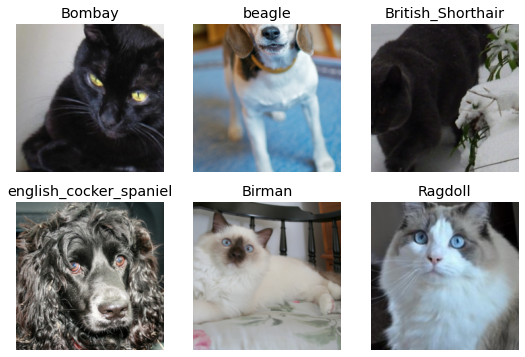

In [9]:
loaders.show_batch(nrows=2, ncols=3)

### Debugging: Data Preprocessing
In general, it is very useful to be able to see step by step how our data is getting loaded. The `DataBlock` API supports this with the `summary` method, which provides all kinds of useful information, from the size of each dataset (training and validation) to the parameters used in each stage of data preprocesssing:

In [9]:
data_template.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_breed_name -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pug_130.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=300x225
  Pipeline: get_breed_name -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/pug_130.jpg
    applying get_breed_name gives
      pug
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(29)

Final sample: (PILImage mode=RGB size=300x225, TensorCategory(29))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_breed_name -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up a

## Fine-tuning a Pre-trained Model

In [7]:
learner = fai.vision_learner(loaders, fai.resnet34, metrics=fai.error_rate)
learner.fine_tune(2)

/opt/conda/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.502398,0.340065,0.108931,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.502436,0.316975,0.103518,00:42
1,0.329829,0.231249,0.073072,00:42


Let's train the very same model again and see what happens:

In [8]:
learner = fai.vision_learner(loaders, fai.resnet34, metrics=fai.error_rate)
learner.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.531190,0.364123,0.116373,00:33


epoch,train_loss,valid_loss,error_rate,time
0,0.518063,0.307048,0.101489,00:43
1,0.331659,0.227355,0.079161,00:43


As you can see, the results are kind of similar in magnitude, but they're obviously not the same. This is because the initialization of the network is not the same. To ensure complete reproducibility, we must ensure the random initialization is done from the same seed to the PNRG.

### Getting Predictions Manually
Of course, it is also possible to see what predictions from the above model look like. 
All we need is to simulate one batch of data as follows:

In [18]:
x, y = loaders.one_batch()
y.shape, len(y.shape)

(torch.Size([64]), 1)

In [19]:
predictions, targets = learner.get_preds(dl=[(x, y)])
predictions[0]

tensor([1.5097e-03, 1.0922e-03, 7.5545e-04, 1.3694e-04, 6.2001e-04, 1.2892e-03, 3.3299e-04, 1.1099e-03, 1.3002e-03, 5.1728e-04, 8.9093e-03, 3.3192e-03, 1.0238e-01, 1.2284e-01, 1.5046e-02, 9.4289e-02,
        7.4620e-02, 4.2835e-02, 4.5306e-03, 1.6487e-03, 3.0398e-03, 1.6852e-02, 3.6417e-03, 1.5993e-02, 1.3239e-03, 4.4474e-03, 1.4887e-02, 3.4922e-04, 1.4943e-02, 3.5421e-01, 1.7672e-02, 5.7975e-03,
        2.1502e-04, 1.1680e-02, 4.8443e-02, 4.9909e-03, 2.4364e-03])

In [20]:
len(predictions[0]), predictions[0].sum()

(37, tensor(1.0000))

As expected, our predictions over all dog breeds form a probability distribution that sums up to 1.0

## Analyzing Mistakes
As usual, it's important to analyze the mistakes of our model. `ClassificationInterpretation` is a very useful class for this purpose:

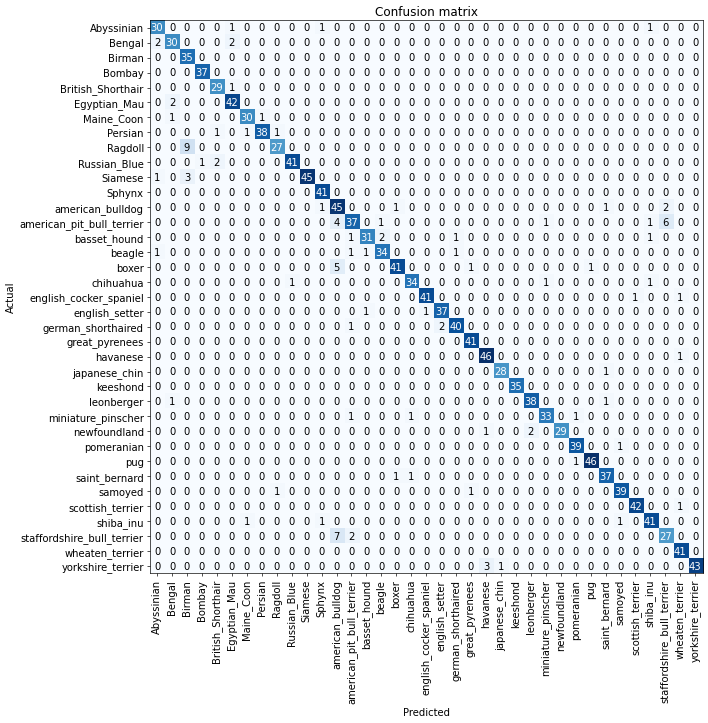

In [25]:
interpretation = fai.ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In general, the model makes very few mistakes, but it does seem to get confused with some breeds. To see which ones, we can use the `most_confused` method as follows:

In [26]:
interpretation.most_confused(min_val=5)

[('Ragdoll', 'Birman', 9),
 ('staffordshire_bull_terrier', 'american_bulldog', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('boxer', 'american_bulldog', 5)]

We can also use the `plot_top_losses` method to see additional information on samples where the model had trouble. Even when the model made the correct classifications, this can be useful to detect where the model has the least confidence in its predictions:

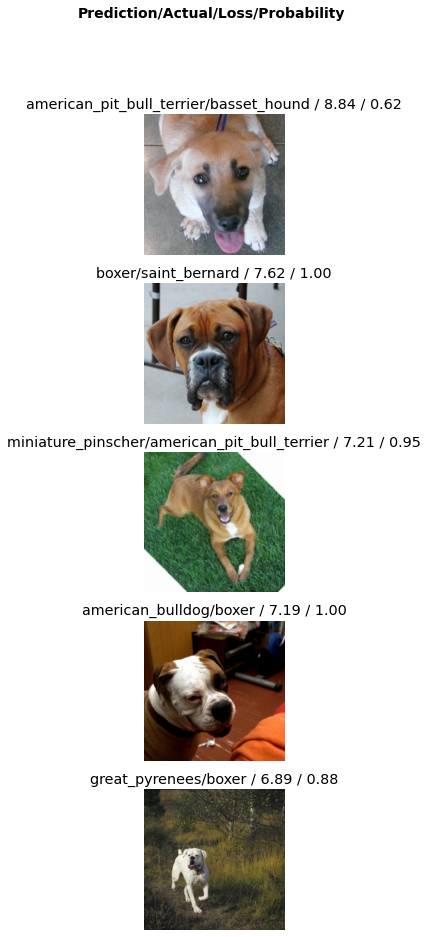

In [27]:
interpretation.plot_top_losses(5, ncols=1)

It looks like the mistakes are not terrible, but our model has definitely not fully learned some key features to distinguish between the breeds above.

## Reducing the Error Rate
The learning rate is a key ingredient to helping our model learn fast and reduce the error rate. In this section, we'll see a couple of tecniques to find the most suitable learning rate for our problem.

The first technique is the learning rate finder, which is built-in as the `lr_find` method in every learner. If you need a reminder on this technique, you can read [this post](https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it)

SuggestedLRs(valley=0.0012022644514217973)

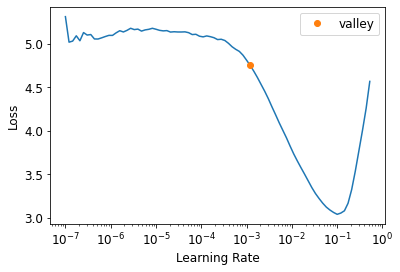

In [28]:
learner = fai.vision_learner(loaders, fai.resnet34, metrics=fai.error_rate)
result = learner.lr_find(); result

Once we have a found a suitable learning rate, we can call `fine_tune`, which will freeze all weights in the "body" of the model (the feature extractor for a CNN) and train the "head" (the classifier) for one epoch. 

We will then unfreeze all weights and train the whole network for 2 more epochs.

This approach is needed to ensure that the weights learned in the feature extractor are not heavily reconfigured during the initial fine-tuning of the new head (the specific dog breeds classifier for our model).

In [30]:
learner = fai.vision_learner(loaders, fai.resnet34, metrics=fai.error_rate)
learner.fine_tune(2, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.920746,0.391956,0.123139,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.539305,0.304923,0.100135,00:44
1,0.388302,0.236835,0.081191,00:44


Unfortunately, this doesn't seem to have improved our error rate much (in fact, it seems to have gotten worse).

This is not totally surprising, though, as `fastai` defaults to the same learning rate we used here.

## Different Learning Rates for Head and Body
We can also run the previous training in a more controlled manner by fine-tuning the head for more epochs by calling `fit_one_cycle` (which is called under the hood by `fine_tune`), followed by a full training with a new learning rate (automatically found with the learning rate finder):

In [31]:
learner = fai.vision_learner(loaders, fai.resnet34, metrics=fai.error_rate)
learner.fit_one_cycle(3, 1e-3)
learner.unfreeze()

epoch,train_loss,valid_loss,error_rate,time
0,1.679826,0.316875,0.098106,00:35
1,0.658093,0.256996,0.079161,00:35
2,0.409019,0.242874,0.073748,00:36


SuggestedLRs(valley=3.630780702224001e-05)

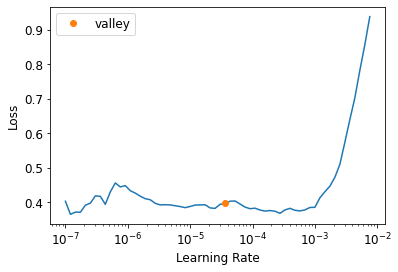

In [38]:
learner.lr_find()

In [39]:
learner.fit_one_cycle(6, lr_max=5e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.382935,0.229629,0.074425,00:43
1,0.354469,0.225502,0.069689,00:42
2,0.261495,0.226599,0.075778,00:42
3,0.212864,0.193547,0.065629,00:43
4,0.167265,0.187444,0.056157,00:43
5,0.153496,0.181239,0.056157,00:43


## Learning Rate Schedule
Yet another technique we can use to improve is to use cyclical learning rates (another contribution by Leslie Smith, the same person who came up with the learning finder), as illustrated in the following picture:

![Cyclical Learning Rate](https://iconof.com/static/5077dd3668a084c1059abce622ab4310/07975/clr.png)

If you need a reminder on this technique, see [this post](https://iconof.com/1cycle-learning-rate-policy/)

In [40]:
learner = fai.vision_learner(loaders, fai.resnet34, metrics=fai.error_rate)
learner.fit_one_cycle(3, 3e-3)

learner.unfreeze()
learner.fit_one_cycle(6, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.152435,0.338742,0.101489,00:34
1,0.524914,0.237938,0.074425,00:34
2,0.314825,0.220664,0.067659,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.259478,0.212284,0.069689,00:43
1,0.232176,0.200831,0.062246,00:43
2,0.223150,0.186131,0.058863,00:42
3,0.202118,0.186662,0.062923,00:43
4,0.174591,0.185920,0.057510,00:42
5,0.175878,0.191932,0.060893,00:42


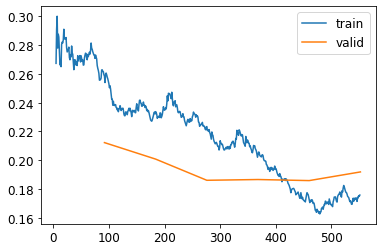

In [42]:
learner.recorder.plot_loss()

## Mixed Precision Training

In [43]:
from fastai.callback.fp16 import to_fp16

learner = fai.vision_learner(loaders, fai.resnet50, metrics=fai.error_rate).to_fp16()
learner.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.296837,0.313147,0.097429,00:55
1,0.557310,0.316438,0.096076,00:55
2,0.410808,0.289060,0.086604,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.297635,0.256069,0.072395,01:07
1,0.320341,0.339174,0.091340,01:07
2,0.244790,0.293657,0.093369,01:07
3,0.147940,0.274454,0.077808,01:08
4,0.097355,0.203307,0.061570,01:08
5,0.065500,0.189825,0.061570,01:08


# Questions

**1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?**

The first resize on the CPU serves two purposes: to bring all images to a uniform size, and to allow for data augmentation using subregions of the image (presizing). The alternative--to resize with squishing or with empty borders--would likely introduce many distortion artifacts that would affect the model's accuracy.

Of course, the initial resize to a larger size also introduces a distortion (because new synthetic pixels have to be created), but empirically it seems that this is less problematic than the alternative.

The second resize is to make sure the data fits on the GPUs memory (and is the expected size for the model we're currently training -- in the case of CNNs which do not end with aa global average pooling layer)

**2. If you're not familiar with regular expressions, find a regular expressioon tutorial and some problem sets, and complete them. Have a look on the book's website for suggestions.**

[This](https://regexr.com/) is a pretty cool website for learning and building regular expressions online. It not only validates "regexps", but also provides explanations for individual pieces of them.

**3. What are the two ways in which data is most commonly provided for most deep learning datasets?**

One way is by encoding the name of labels or other metadata into the name of the files or folders in which the data is stored. Another way is to have a separate file with the same information (e.g., a file that maps files paths of images to their corresponding label)

**4. Look up the documentation for `L` and try using a few of the methods that it adds**

In [22]:
help(fai.L)

Help on class L in module fastcore.foundation:

class L(fastcore.basics.GetAttr, CollBase)
 |  L(items=None, *rest, use_list=False, match=None)
 |  
 |  Behaves like a list of `items` but can also index with list of indices or masks
 |  
 |  Method resolution order:
 |      L
 |      fastcore.basics.GetAttr
 |      CollBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(a, b)
 |  
 |  __addi__(a, b)
 |  
 |  __contains__(self, b)
 |  
 |  __eq__(self, b)
 |      Return self==value.
 |  
 |  __getitem__(self, idx)
 |      Retrieve `idx` (can be list of indices, or mask, or int) items
 |  
 |  __init__(self, items=None, *rest, use_list=False, match=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __invert__(self)
 |  
 |  __iter__(self)
 |  
 |  __mul__(a, b)
 |  
 |  __radd__(a, b)
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  __reversed__(self)
 |  
 |  __setitem__(self, idx, o)
 |      Set `idx` (can be list o

In [7]:
fai.L.split('1.2.3', '.')

(#3) ['1','2','3']

In [8]:
fai.L(['height', 'width', 'depth']).argwhere(lambda item: item.startswith('h'))

(#1) [0]

In [11]:
fai.L(['a', 'b', 'c']).enumerate()

(#3) [(0, 'a'),(1, 'b'),(2, 'c')]

In [12]:
fai.L([1, 2, 3]).product()

6

**5. Look up the documentation for the Python `pathlib` module and try using a few methods of the `Path` class.**

In [13]:
from pathlib import Path

Path.home()

Path('/root')

In [14]:
Path.cwd()

Path('/notebooks/scratch')

In [16]:
# ls() is actually not part of the standard library, but an extension
# added by fastai (via "monkey patching")
Path.cwd().ls()

(#25) [Path('/notebooks/scratch/chapter-04.ipynb'),Path('/notebooks/scratch/bears_classifier.ipynb'),Path('/notebooks/scratch/tmp'),Path('/notebooks/scratch/chapter-03.ipynb'),Path('/notebooks/scratch/API.ipynb'),Path('/notebooks/scratch/chapter-05.ipynb'),Path('/notebooks/scratch/chapter-06.ipynb'),Path('/notebooks/scratch/chapter-02.ipynb'),Path('/notebooks/scratch/export.pkl'),Path('/notebooks/scratch/images')...]

In [18]:
Path("~").expanduser()

Path('/root')

In [21]:
fai.L(Path.cwd().glob("*.ipynb"))

(#17) [Path('/notebooks/scratch/chapter-04.ipynb'),Path('/notebooks/scratch/bears_classifier.ipynb'),Path('/notebooks/scratch/chapter-03.ipynb'),Path('/notebooks/scratch/API.ipynb'),Path('/notebooks/scratch/chapter-05.ipynb'),Path('/notebooks/scratch/chapter-06.ipynb'),Path('/notebooks/scratch/chapter-02.ipynb'),Path('/notebooks/scratch/chapter-01.ipynb'),Path('/notebooks/scratch/chapter-10.ipynb'),Path('/notebooks/scratch/chapter 12.ipynb')...]

**6. Give two examples of ways that image transformation can degrade the quality of the data.**

Some kinds of rotations (at angles other than multiples of 90 degrees) and squishing are two examples of transformations where some pixels are destroyed and others are synthesized, thus possibly degrading the original quality of the data.

**7. What method does `fastai` provide to view the data in a `DataLoaders`?**

The `show_batch` method

**8. What method does `fastai` provide to help you debug a `DataBlock`?**

The `summary` method, which shows a trace of the steps of the preprocessing pipeline.

**9. Should you hold off on training a model until you have thoroughly cleaned your data?**

No, sometimes a baseline model can actually be helpful in preparing the data.

**10. What are the two pieces that are combined into cross-entropy loss in PyTorch?**

The calculation of the actual cross-entropy function (the KL divergence, to be more precise; see [this resource](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)), and the log of the softmax activations.

**11. What are the two properties of activations that softmax ensures? Why is this important?**

One is that the values will be between 1 and 0 (i.e., they will turn possibly negative activations into positive numbers), which can be interpreted as a probability. The second is that the values of all activations will always sum up to 1, thus allowing us to interpret the full result as a probability distribution. 

This is well-suited for single-label classification, where we aim for a single result.

**12. When might you want your activations to not have these two properties?**

When you want to tag more than one object in each image (i.e., in multi-label classification)

**14. Why can't we use `torch.where` to create a loss function for datasets where our label can have more than two categories?**

Because `torch.where` is an inherently binary function, so it cannot accommodate multiple classes.

**15. What is the value of `log(-2)`? Why?**

It's a complex number. It is not defined in the real numbers because it's equivalent to solving for `e` in this equation: `B^e = -2` for `B >= 1`. There is no solution in real numbers.

**16. What are two good rules of thumb for picking up the learning rate from the learning rate finder?**

Use either the last value where the loss was clearly decreasing, or use a value an order of magnitude smaller than where the minimum loss was found.

**17. What two steps does the `fine_tune` method do?**

It first freezes all layers in the head of the model (this may vary from architecture to architecture) and trains for one epoch. It then unfreezes all layers and trains for the number of epochs specified.

**18. In Jupyter Notebook, how do you get the source code for a method or function?**

You can type `method_name??`

**19. What are discriminative learning rates?**

They're different learning rates that are applied according to which layer a weight belongs to. Weights in the last layers get larger learning rates, while those in the first ones get smaller ones. This works well for transfer learning, but there's some evidence that this may not work as well for networks trained fully from scratch (see [this discussion](https://forums.fast.ai/t/discriminative-learning-rates-when-training-from-scratch/43967/6))

**20. How is a Python `slice` object interpreted when passed as a learning rate to `fastai`?**

As a range of learning rates to be used at different layers, from smallest to largest. The intermediate values are calculated uniformly according to the number of layers present.

**21. Why is early stopping a poor choice when using `1cycle` training?**

Because since the learning rates gradually increases and then decreases after a peak, it is possible that there will be epochs during which the loss increases. So maybe a naive version of early stopping could be a bad idea, but in frameworks like `Keras` there are ways to control this via callbacks (e.g., by adding some "grace" period before halting), so it may still be useful.

**22. What is the difference between `resnet50` and `resnet101`?**

Basically the number of layers. The building blocks of the architecture is essentially the same.

**23. What does `to_fp16` do?**

It enables core tensors when using NVIDIA GPUs. This accelerates training by using mixed precision floating point, and uses less memory in the GPU.

# Further Research

**1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.**

The paper can be found [here](https://arxiv.org/pdf/1803.09820.pdf)

**2. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve?** Look on the forums and the book's website to see what other students have achieved with this dataset and how they did it.